**Importing the Data**

In [297]:
import pandas as pd
import numpy as np

In [298]:
df = pd.read_csv("/content/hate.csv", encoding ="unicode_escape")
df

,Unnamed: 0,comment,label
0,1,dalits are lowlives,N
1,2,gay people are a burden to our society,N
2,3,Arabs are not welcome,N
3,4,I'm not saying we should actually eliminate he...,N
4,5,bananas are for black people,N
...,...,...,...
41139,117100,Indian culture is so backwards,N
41140,118100,"Women don't want equality, they just want to b...",N
41141,119100,fuck covid,P
41142,1205,This computer is garbage,P


In [299]:
df.columns

Index(['Unnamed: 0', 'comment', 'label'], dtype='object')

**Data Preprocessing**

In [300]:
df = df.drop(["Unnamed: 0"], axis = 1)

In [301]:
df.columns

Index(['comment', 'label'], dtype='object')

In [302]:
df.head()

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N


In [303]:
df["label"].value_counts()

N    22158
P    18950
O       36
Name: label, dtype: int64

In [304]:
import string
exclude = string.punctuation
exclude

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [305]:
def remove_punc(text):
    for special_char in exclude:
        text = text.replace(exclude, " ")
    return text

In [306]:
df["comment"] = df["comment"].apply(remove_punc)
df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


In [307]:
df["comment"] = df["comment"].str.lower()
df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,arabs are not welcome,N
3,i'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,indian culture is so backwards,N
41140,"women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,this computer is garbage,P


In [308]:
df['comment'] = df['comment'].str.strip()

In [309]:
import nltk
from nltk.corpus import stopwords

In [310]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [311]:
def stop_words(text):
  new_text = []
  for word in text.split():
    if word in stopwords.words("english"):
      new_text.append(" ")

    else:
      new_text.append(word)
  x = new_text[:]
  new_text.clear()
  return " ".join(x)

In [312]:
df["comment"] = df["comment"].apply(stop_words)
df

,comment,label
0,dalits lowlives,N
1,gay people burden society,N
2,arabs welcome,N
3,i'm saying actually eliminate heebs.. ...,N
4,bananas black people,N
...,...,...
41139,indian culture backwards,N
41140,"women want equality, want charge",N
41141,fuck covid,P
41142,computer garbage,P


In [313]:
from sklearn.model_selection import train_test_split

In [314]:
X = df["comment"]
Y = df["label"]

In [315]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [316]:
from keras.preprocessing.text import Tokenizer

In [317]:
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [318]:
vocab_len = len(word_tokenizer.word_index) +1
vocab_len

26620

In [319]:
from keras.preprocessing.sequence import pad_sequences

max_len = 12

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [320]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [321]:
# embedding_matrix = zeros((vocab_len, 100))
# for word, index in word_tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector


embedding_matrix = np.zeros((vocab_len, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and len(embedding_vector) == 100:
        embedding_matrix[index] = embedding_vector
    else:
        pass

In [322]:
embedding_matrix.shape

(26620, 100)

In [324]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [325]:
all_labels = pd.concat([Y_train, Y_test])

encoder = LabelEncoder()
encoder.fit(all_labels)

Y_train = encoder.transform(Y_train)
Y_test = encoder.transform(Y_test)

In [326]:
Y_test

array([0, 0, 2, ..., 0, 2, 0])

**Model Building, Training and Evaluation**

In [327]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from keras.layers import Bidirectional
import tensorflow as tf

In [349]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_len, output_dim=100, input_length=max_len))


model1.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
model1.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model1.add(Bidirectional(LSTM(64,dropout=0.2)))

model1.add(Dense(3, activation='sigmoid'))

model1.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 30, 100)           2662000   
                                                                 
 bidirectional_71 (Bidirect  (None, 30, 512)           731136    
 ional)                                                          
                                                                 
 bidirectional_72 (Bidirect  (None, 30, 256)           656384    
 ional)                                                          
                                                                 
 bidirectional_73 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_61 (Dense)            (None, 3)                 387       
                                                     

In [350]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])

In [345]:
lstm_model_history1 = model1.fit(X_train, Y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/5
258/258 [==============================] - 129s 474ms/step - loss: 0.6798 - acc: 0.5699 - val_loss: 0.6247 - val_acc: 0.6077
Epoch 2/5
258/258 [==============================] - 124s 483ms/step - loss: 0.5588 - acc: 0.6911 - val_loss: 0.6113 - val_acc: 0.6565
Epoch 3/5
258/258 [==============================] - 122s 474ms/step - loss: 0.4740 - acc: 0.7592 - val_loss: 0.6375 - val_acc: 0.6342
Epoch 4/5
258/258 [==============================] - 123s 477ms/step - loss: 0.4025 - acc: 0.8077 - val_loss: 0.7203 - val_acc: 0.6268
Epoch 5/5
258/258 [==============================] - 124s 481ms/step - loss: 0.3385 - acc: 0.8441 - val_loss: 0.8407 - val_acc: 0.6210


In [348]:
model1.evaluate(X_test, Y_test)

258/258 [==============================] - 9s 32ms/step - loss: 0.8407 - acc: 0.6210


[0.8406585454940796, 0.620974600315094]

**Visualizing Model's Performance**

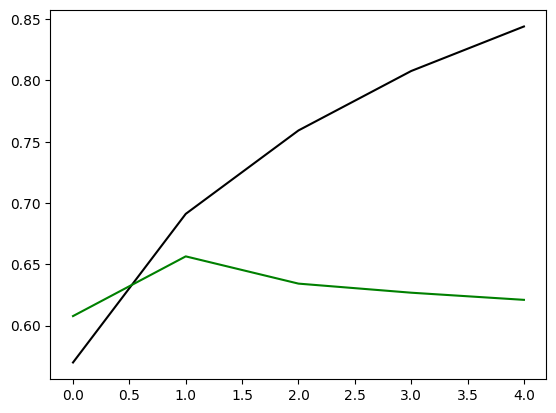

In [347]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history1.history["acc"],color = "black")
plt.plot(lstm_model_history1.history["val_acc"], color = "green")